In [1]:
from sklearn import datasets
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
def load_iris(ratio=0.8, binarization=True):
    features, target = datasets.load_iris(True)
    
    if binarization:
        # 将连续特征离散化 -- 根据每个特征的均值作一个简单的二分类
        num_feature = features.shape[-1]
        feature_mean = np.mean(features, axis=0)
        for i in range(num_feature):
            features[:, i] = features[:, i] <= feature_mean[i]
    
    num_samples = len(target)
    num_train = math.ceil(num_samples * ratio)
    
    # 随机打乱数据
    idx = np.random.permutation(np.arange(num_samples))
    traindata = features[idx[:num_train]], target[idx[:num_train]]
    validdata = features[idx[num_train:]], target[idx[num_train:]]
    
    return traindata, validdata

# 作业三

## 三、决策树分类器

使用C4.5算法和信息增益比来构造决策树

前置需求：需要掌握递归的概念

请按顺序实现以下几个功能：

1. 仿造信息增益的代码，实现信息增益比(IGR) -- 2分 (ETA: ~2小时)
2. 从相对的特征下标还原出绝对下标 -- 1分 (ETA: ~1小时)
3. 补充完整树的递归构造部分 -- 2分 (ETA: 3~5小时)
4. 实现剪枝部分的代码 -- 4分 (ETA: unknown)

ETA：>10 hours

读取数据

In [3]:
(X_train, Y_train), (X_valid, Y_valid) = load_iris()

### 一、定义信息增益(IG)与信息增益比(IGR)

In [4]:
# 不需要修改
def IG(features, targets, index=None):
    """
    计算信息增益 (information gain) -- equation (5.9)
    
    Inputs:
      index: None or int
        关于features[idx]的信息增益比；若idx为None则计算关于所有特征的信息增益比
      features: array of shape (N, C) or (C, )
        输入特征
      targets : array of shape (N, )
        类别
    
    Outputs:
      gains: array of shape (N, C) or number
    """
    
    def H(targets):
        """estimate entropy -- equation (5.7)"""
        target_labels = np.unique(targets)
        K = len(target_labels)
        num_D = len(targets) # |D|
        num_Ck = np.array([np.sum(targets == ck) for ck in target_labels])
        
        return -np.sum(num_Ck/num_D * np.log2(num_Ck/num_D))
    
    
    def H_cond(feature, targets):
        """estimate entropy conditional on feature -- equation (5.8)"""
        # equation (5.8)
        feature_labels = np.unique(feature)
        num_Di = np.array([np.sum(feature == di) for di in feature_labels])
        num_D = np.sum(num_Di)
        
        H_Di = np.array([H(targets[feature == di]) for di in feature_labels])
        return np.sum(num_Di/num_D * H_Di)
    
    
    assert features.shape[0] == targets.shape[0]
    
    # if no idx is provided, calcuate IG with regard to all features
    if index is None:
        num_features = features.shape[-1]
        return np.array([IG(X_train, Y_train, idx) for idx in range(num_features)])
    
    # equation (5.9)
    feature = features[:, index]
    return H(targets) - H_cond(feature, targets)

测试IG是否正常工作

In [5]:
IG(X_train, Y_train)

array([0.48732446, 0.23328937, 0.7896989 , 0.75985393])

In [6]:
IG(X_train, Y_train, index=0)

0.48732446329948775

In [7]:
def IGR(features, targets, index=None):
    """
    计算信息增益比 (information gain ratio) -- equation (5.10)
    
    Inputs:
      index : None or int
        关于features[idx]的信息增益比；若idx为None则计算关于所有特征的信息增益比
      features : array of shape (N, C) or (C, )
        输入特征
      targets : array of shape (N, )
        类别
    
    Outputs:
      gains: array of shape (N, C) or number
    """
    
    # 实现它
    # 大约30行代码
    raise(NotImplementedError())
    return None

测试IGR是否正常工作

In [8]:
IGR(X_train, Y_train)

array([0.6006873 ,       -inf, 0.97340096,       -inf])

In [9]:
IGR(X_train, Y_train, index=0)

0.6006872965105275

### 二、决策树的构造

#### 计算当前训练集中实例数最大的类

In [10]:
# 不需要修改
def find_largest_class(targets):
    target_labels = np.unique(targets)
    idx = [targets==ai for ai in target_labels]
    Ck_i = [np.sum(i) for i in idx]
    label_idx = np.argmax(Ck_i)
    label = target_labels[label_idx]
    return label

In [11]:
find_largest_class(Y_train)

0

#### 从相对的特征下标还原出绝对下标

因为在递归构造决策树的时候涉及到特征集的划分，因此要解决的一个问题是：

假设原先为4维数组，依次删除它的第`3, 2, 1`维，则最后剩下的第`0, 1`维分别是原先数组中的第几维？(0, 4)

* ori: [a0, a1, a2, a3, a4]
* 3  : [a0, a1, a2, a4]
* 2  : [a0, a1, a4]
* 1  : [a0, a4]

依次删除它的第`1, 2, 2`维， 那么剩下的第`0`维是原先数组中的第几维？ (0, 2)

* ori: [a0, a1, a2, a3, a4]
* 1  : [a0, a2, a3, a4]
* 2  : [a0, a2, a4]
* 2  : [a0, a2]

如果是`0, 0, 0`维，那么剩下的第`0`维是原先数组的第几维？(3, 4)

* ori: [a0, a1, a2, a3, a4]
* 3  : [a1, a2, a3, a4]
* 2  : [a2, a3, a4]
* 1  : [a3, a4]


In [12]:
def absolute_index(relative_idx, removed_indices=None):
    # 实现它
    # 大约10行代码
    raise(NotImplementedError())
    return None

In [13]:
print(absolute_index(0, [3, 2, 1]))
print(absolute_index(1, [3, 2, 1]))
print(absolute_index(0, [1, 2, 2]))
print(absolute_index(1, [1, 2, 2]))
print(absolute_index(0, [0, 0, 0]))
print(absolute_index(1, [0, 0, 0]))

0
4
0
2
3
4


In [19]:
class DecisionTree:
    """
    Attributes:
      label : int or None
        当前节点对应的分类标签; 只有叶节点才具有标签
      children : array of DecisionTree
        子树；若为空，则代表当前节点为叶节点，不再向下细分
      decision_rule : function
        从当前节点向下细分时调用的决策函数
      feature_idx : int
        当前节点作分类时所判断的特征下标 -- 绘图用
      feature_value : array of number
        当前节点作分类时所判断的特征的对应值 -- 绘图用
    """
    def __init__(self, eps = 0.1, gain_method = IG):
        """
        Inputs:
          eps : number
            Alg. 5.2 与 5.3中第四步的阈值，用来避免构造“过细”的节点（默认为0.1）
          gain_method : function
            增益计算函数，默认为 IG (信息增益)
        """
        self.gain_method = gain_method
        self.eps = eps # Alg. 5.1 与 Alg. 5.3 中的阈值
        
        self.label = None
        self.feature_value = None
        self.feature_idx = None
        self.decision_rule = None
        self.children = [] # 子树
        
        
    def __call__(self, features):
        return self.predict(features)
    
    def __str__(self):
        return str(self.label) # required by networkX
    
    def fit(self, features, targets):
        self._generate_tree(features, targets)
        self._prune_tree(features, targets)
        
        
    def _generate_tree(self, features, targets, removed_indices=None):
        # 以算法5.2及5.3中描述的过程构造决策树
        # 该算法为递归结构：
        # 第 (1)-(3) 步为递归的终止条件
        # 第 (4)-(5) 构造当前分支的结构
        # 第 (6) 通过递归调用来实现完整的树的构造
        
        # 在递归过程中特征集会被不断压缩与裁剪，因此当前分支构造时的特征下标并等于训练集中的下标
        # 因此这里需要记录之前的特征下标，从而还原出当前特征在原训练集中的位置
        if removed_indices is None:
            removed_indices = []
        
        ### 终止条件
        # step (1) -- early stop if all targets are of the same class
        target_labels = np.unique(targets)
        if target_labels.size == 1:
            self.label = target_labels[0]
            return None
        
        # step (2) -- early stop if it's an empty feature set
        if features.size == 0:
            self.label = find_largest_class(targets)
            return None
        
        # step (3) -- find the most significant feature
        gains = self.gain_method(features, targets)
        feature_idx = np.argmax(gains)
        
        # step (4) -- early stop if all features are insignificant
        if gains[feature_idx] < self.eps:
            self.label = find_largest_class(targets)
            return None
        
        ### 递归过程
        cur_feature = features[:, feature_idx]
        cur_feature_labels = np.unique(cur_feature)
        
        # 1. generate a decision rule for current node
        
        if self.label is None:
            # self.label is assigned by its parent node -- root node has no parent node
            # so we manually generate one label for it
            self.label = find_largest_class(targets)
        self.feature_value = cur_feature_labels
        self.feature_idx = absolute_index(feature_idx, removed_indices)
        self.decision_rule = lambda x: x[feature_idx] == cur_feature_labels # onehot encoding
        removed_indices.append(feature_idx)
        
        # recusively label all children nodes
        self.children = [DecisionTree(self.eps, self.gain_method) for _ in cur_feature_labels]
        # 实现它
        # 大约10行代码
        raise(NotImplementedError())
            
    
    def _prune_tree(self, features, targets):
        # 实现它
        pass
    
    
    def predict(self, features):
        # 预测单个数据
        if len(features.shape) == 1:
            return np.array([self._predict_single(features)])
        # 批量预测
        elif len(features.shape) == 2:
            N = features.shape[0]
            out = np.zeros((N, ))
            for i in range(N):
                out[i] = self._predict_single(features[i, :])
            return out
        else:
            raise(ValueError("Unsupported features size, should be 1 or 2 dimensional"))
    
    
    def _predict_single(self, feature):
        if len(self.children) == 0:
            return self.label
        else:
            child_idx = np.argmax(self.decision_rule(feature))
            child = self.children[child_idx]
            return child._predict_single(feature)
            

### 三、决策树的绘制

In [15]:
# 不需要修改
def plot_tree(tree: DecisionTree):
    G = generate_graph(tree)
    pos = generate_position(tree)
    edge_labels = generate_labels(tree)
    color = generate_color(tree, G)
    
    nx.draw(G, pos, with_labels=True,
            node_size=200, linewidths=5,
            node_color=color, vmax=np.max(color)*1.5, cmap=plt.cm.Blues)
    
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels = edge_labels)
    
    
def generate_graph(tree):
    """从DecisionTree中生成一个有向图"""
    
    def _generate_graph(graph, tree):
        for child in tree.children:
            G.add_edge(tree, child, len=40)

        for child in tree.children:
            _generate_graph(graph, child)
    
    G = nx.DiGraph()
    _generate_graph(G, tree)
    return G


def generate_labels(tree):
    """从DecisionTree中生成一个每条边的决策信息"""
    def _generate_labels(labels, tree):
        if len(tree.children) == 0:
            return None

        for (child, value) in zip(tree.children, tree.feature_value):
            labels[(tree, child)] = f"X[{tree.feature_idx}] == {value}"

        for child in tree.children:
            _generate_labels(labels, child)
            
    labels = {}
    _generate_labels(labels, tree)
    return labels


def generate_position(tree):
    """生成一个树状的位置信息"""
    def _generate_position(pos, tree, level=1, max_level=20):

        if tree not in pos:
            pos[tree] = np.array([0, 0])

        y_offset = -1
        x_offsets = np.arange(len(tree.children))
        x_offsets = x_offsets - np.mean(x_offsets)
        for (child, x_offset) in zip(tree.children, x_offsets):
            # offsets are scaled wrt current level to avoid overlap of nodes
            pos[child] = pos[tree] + np.array([x_offset, y_offset]) * (max_level-level)/max_level

        for child in tree.children:
            _generate_position(pos, child, level+1)
    
    
    pos = {}
    _generate_position(pos, tree)
    return pos


def generate_color(tree, graph, max_level=20):
    def _generate_color(color, tree, level=1):
        if tree not in color:
            color[tree] = level

        for child in tree.children:
            color[child] = level + 1
            _generate_color(color, child, level+1)
    
    
    color = {}
    _generate_color(color, tree)
    return np.array([color[x] for x in graph.nodes])

### 四、测试算法

In [16]:
def accuracy(model):
    return np.sum(model.predict(X_valid) == Y_valid)/Y_valid.size

对数据特征进行二分类

accuracy:0.8000


/opt/conda/envs/pt-stable/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/envs/pt-stable/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/envs/pt-stable/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/opt/conda/envs/pt-stable/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


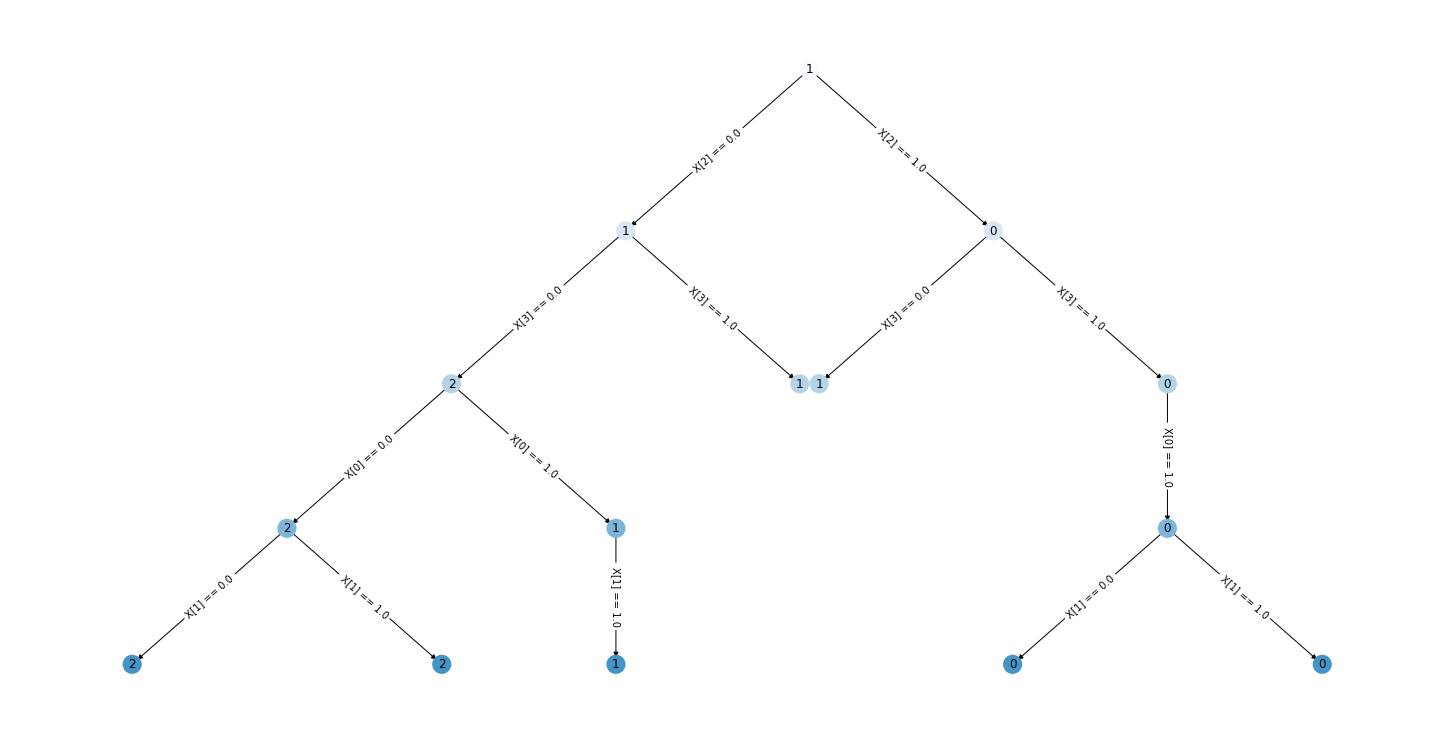

In [17]:
(X_train, Y_train), (X_valid, Y_valid) = load_iris(binarization=True)

model = DecisionTree(gain_method=IGR)
model.fit(X_train, Y_train)

print(f"accuracy:{accuracy(model):.4f}")

fig = plt.gcf()
fig.set_size_inches(20, 10)
plot_tree(model)

不对数据特征进行二分类

In [18]:
(X_train, Y_train), (X_valid, Y_valid) = load_iris(binarization=False)

model = DecisionTree(gain_method=IGR)
model.fit(X_train, Y_train)

print(f"accuracy:{accuracy(model):.4f}")

# fig = plt.gcf()
# fig.set_size_inches(20, 10)
# plot_tree(model)

accuracy:0.8000
